#**Wallet Risk Scoring : Assignment 2**

Author : Ayantika Dhar


#Data loading, generating features and preprocessing

In [1]:
import pandas as pd
!pip install requests
import requests
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances


In [2]:
wallets_df = pd.read_csv('/content/drive/MyDrive/ZERUU/wallet_addresses.csv')
wallets_df.columns = wallets_df.columns.str.strip()
print(wallets_df.head())

                                    wallet_id
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1  0x06b51c6882b27cb05e712185531c1f74996dd988
2  0x0795732aacc448030ef374374eaae57d2965c16c
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae


In [3]:
COVALENT_API_KEY = "cqt_rQXCkXFX63gX7dmQdvH6WPT9bKfh"
CHAIN_ID = 1  # Ethereum Mainnet

def get_wallet_transactions(wallet_address, page_size=100):
    url = f"https://api.covalenthq.com/v1/{CHAIN_ID}/address/{wallet_address}/transactions_v2/"
    params = {
        "key": COVALENT_API_KEY,
        "page-size": page_size
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error for {wallet_address}: {response.status_code}")
        return None
'''sample_wallet = wallets_df.iloc[0, 0]
tx_data = get_wallet_transactions(sample_wallet)
print(tx_data['data']['items'][:2])  # Preview first 2 transactions'''






"sample_wallet = wallets_df.iloc[0, 0]\ntx_data = get_wallet_transactions(sample_wallet)\nprint(tx_data['data']['items'][:2])  # Preview first 2 transactions"

In [4]:
def extract_wallet_features(tx_items):
    if not tx_items:
        return {
            'tx_count': 0,
            'tx_success_rate': 0,
            'avg_gas_spent': 0,
            'avg_tx_value_eth': 0,
            'defi_interaction_count': 0,
            'wallet_age_days': 0,
            'tx_frequency_per_day': 0
        }

    tx_count = len(tx_items)
    success_count = sum(1 for tx in tx_items if tx['successful'])
    avg_gas_spent = sum(float(tx['gas_spent']) for tx in tx_items) / tx_count
    avg_tx_value_eth = sum(float(tx['value']) / 1e18 for tx in tx_items) / tx_count

    known_defi_contracts = ['compound', 'aave', 'maker', 'curve', 'uniswap']
    defi_tx_count = sum(
        1 for tx in tx_items if any(proto in (tx.get('to_address_label') or "").lower() for proto in known_defi_contracts)
    )

    tx_dates = [datetime.fromisoformat(tx['block_signed_at'].replace("Z", "+00:00")) for tx in tx_items]
    tx_dates.sort()
    wallet_age_days = (tx_dates[-1] - tx_dates[0]).days + 1
    tx_frequency = tx_count / wallet_age_days if wallet_age_days > 0 else 0

    return {
        'tx_count': tx_count,
        'tx_success_rate': success_count / tx_count,
        'avg_gas_spent': avg_gas_spent,
        'avg_tx_value_eth': avg_tx_value_eth,
        'defi_interaction_count': defi_tx_count,
        'wallet_age_days': wallet_age_days,
        'tx_frequency_per_day': tx_frequency
    }


In [5]:
wallet_features = []

for i, wallet in enumerate(wallets_df.iloc[:, 0]):
    print(f"Processing wallet {i+1}/100: {wallet}")
    tx_data = get_wallet_transactions(wallet)
    tx_items = tx_data.get('data', {}).get('items', []) if tx_data else []
    features = extract_wallet_features(tx_items)
    features['wallet_id'] = wallet
    wallet_features.append(features)


Processing wallet 1/100: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
Processing wallet 2/100: 0x06b51c6882b27cb05e712185531c1f74996dd988
Processing wallet 3/100: 0x0795732aacc448030ef374374eaae57d2965c16c
Processing wallet 4/100: 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
Processing wallet 5/100: 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
Processing wallet 6/100: 0x104ae61d8d487ad689969a17807ddc338b445416
Processing wallet 7/100: 0x111c7208a7e2af345d36b6d4aace8740d61a3078
Processing wallet 8/100: 0x124853fecb522c57d9bd5c21231058696ca6d596
Processing wallet 9/100: 0x13b1c8b0e696aff8b4fee742119b549b605f3cbc
Processing wallet 10/100: 0x1656f1886c5ab634ac19568cd571bc72f385fdf7
Processing wallet 11/100: 0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22
Processing wallet 12/100: 0x19df3e87f73c4aaf4809295561465b993e102668
Processing wallet 13/100: 0x1ab2ccad4fc97c9968ea87d4435326715be32872
Processing wallet 14/100: 0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f
Processing wallet 15/100: 0x1e43dacdcf86367

In [6]:
features_df = pd.DataFrame(wallet_features)
features_df.to_csv("/content/drive/MyDrive/ZERUU/wallet_features_raw.csv", index=False)
features_df.head()


,tx_count,tx_success_rate,avg_gas_spent,avg_tx_value_eth,defi_interaction_count,wallet_age_days,tx_frequency_per_day,wallet_id
0,100,0.99,2.358266e+06,0.522546,0,795,0.125786,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1,5,1.00,6.174640e+04,0.004860,0,1,5.000000,0x06b51c6882b27cb05e712185531c1f74996dd988
2,4,1.00,7.269825e+04,0.004650,0,1,4.000000,0x0795732aacc448030ef374374eaae57d2965c16c
3,80,1.00,1.653503e+06,2.523044,0,2068,0.038685,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4,5,1.00,6.174400e+04,0.005201,0,64,0.078125,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae


In [7]:

feature_cols = [
    'tx_count',
    'tx_success_rate',
    'avg_gas_spent',
    'avg_tx_value_eth',
    'defi_interaction_count',
    'wallet_age_days',
    'tx_frequency_per_day'
]

# Step 2: Fit and transform using MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(features_df[feature_cols])

# Step 3: Create a new DataFrame with normalized features
scaled_df = pd.DataFrame(scaled_values, columns=[f"{col}_norm" for col in feature_cols])
scaled_df['wallet_id'] = features_df['wallet_id']


In [8]:
scaled_df.to_csv("/content/drive/MyDrive/ZERUU/wallet_features_scaled.csv", index=False)


#Implementing Wallet Scoring Model

In [15]:

scaled_df = pd.read_csv("/content/drive/MyDrive/ZERUU/wallet_features_scaled.csv")


wallet_ids = scaled_df['wallet_id']
X = scaled_df.drop(columns=['wallet_id'])

# KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Identifying riskiest cluster (lowest tx_success_rate_norm)
cluster_df = pd.DataFrame({'wallet_id': wallet_ids, 'cluster': cluster_labels})
clustered = pd.concat([X.copy(), cluster_df['cluster']], axis=1)
cluster_risk = clustered.groupby('cluster').mean()
safe_order = cluster_risk.sort_values(by='tx_success_rate_norm', ascending=False).index.tolist()
risky_cluster = safe_order[-1]
risky_vector = kmeans.cluster_centers_[risky_cluster]

#Computing distance from risky cluster center
distances = pairwise_distances(X, [risky_vector]).flatten()
dist_scaled = MinMaxScaler().fit_transform(distances.reshape(-1, 1)).flatten()
soft_scores = (1 - dist_scaled) * 1000


cluster_df['soft_score'] = soft_scores.round().astype(int)
cluster_df[['wallet_id', 'soft_score']].to_csv("/content/drive/MyDrive/ZERUU/wallet_risk_scores_soft.csv", index=False)


In [16]:
df = pd.read_csv("/content/drive/MyDrive/ZERUU/wallet_risk_scores_soft.csv")

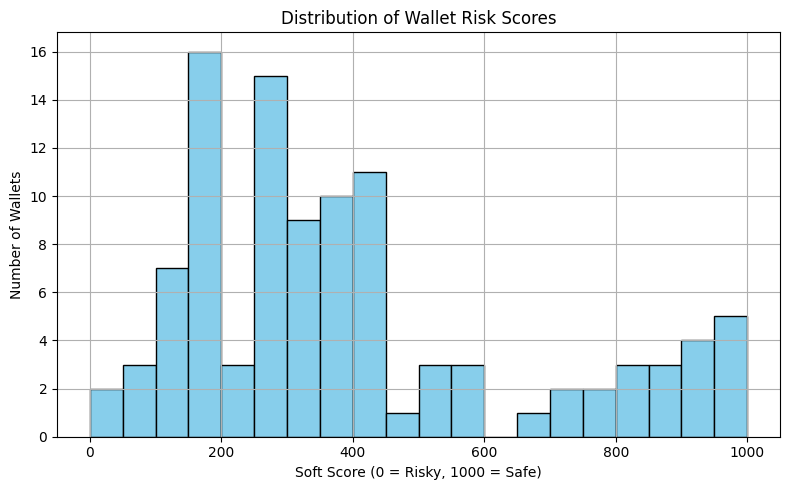

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(df['soft_score'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Wallet Risk Scores")
plt.xlabel("Soft Score (0 = Risky, 1000 = Safe)")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ZERU2/score_distribution_hist.png")
plt.show()

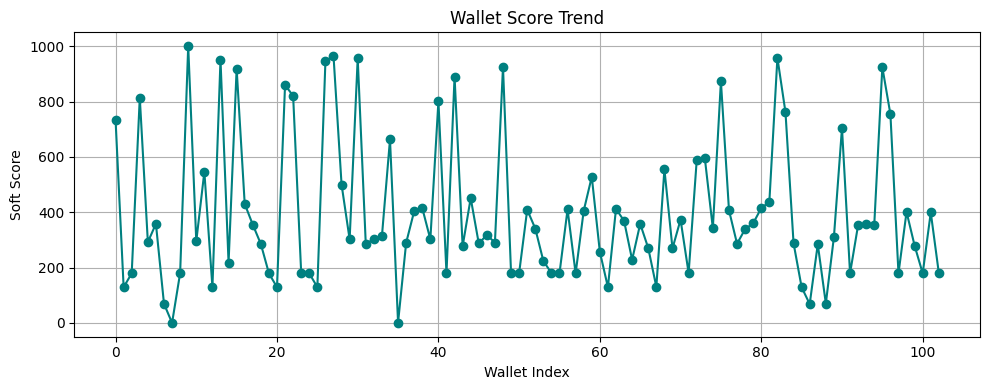

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(df['soft_score'], marker='o', linestyle='-', color='teal')
plt.title("Wallet Score Trend")
plt.xlabel("Wallet Index")
plt.ylabel("Soft Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ZERUU/score_trend_plot.png")
plt.show()


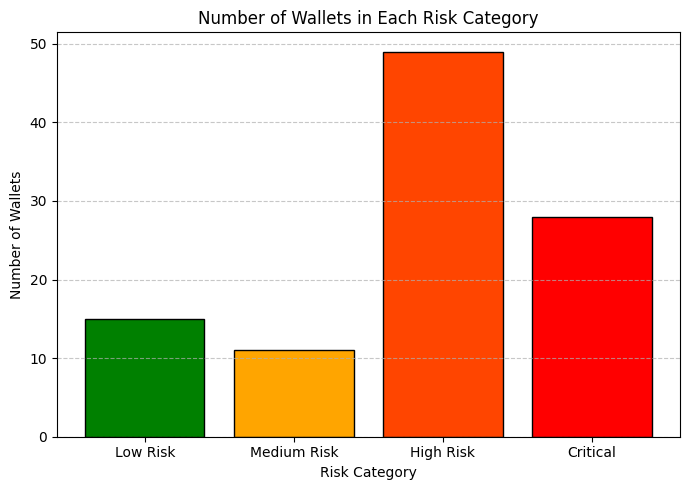

In [20]:
def classify_risk(score):
    if score >= 800:
        return 'Low Risk'
    elif score >= 500:
        return 'Medium Risk'
    elif score >= 200:
        return 'High Risk'
    else:
        return 'Critical'

df['risk_level'] = df['soft_score'].apply(classify_risk)
risk_counts = df['risk_level'].value_counts().reindex(['Low Risk', 'Medium Risk', 'High Risk', 'Critical'])

plt.figure(figsize=(7, 5))
bars = plt.bar(risk_counts.index, risk_counts.values, color=['green', 'orange', 'orangered', 'red'], edgecolor='black')
plt.title("Number of Wallets in Each Risk Category")
plt.xlabel("Risk Category")
plt.ylabel("Number of Wallets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ZERUU/risk_bucket_counts.png")
plt.show()

